In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import argparse
import torch
import transformers 

from tqdm import tqdm
import numpy as np

from model_lib.hf_tooling import HF_Llama2_Wrapper
from model_lib.attention_tools import run_attention_monitor
from factual_queries import load_constraint_dataset
from viz_tools import plot_attention_flow

In [3]:
import argparse
def config():
    parser = argparse.ArgumentParser()
    parser.add_argument("--model_name", type=str, default="meta-llama/Llama-2-13b-hf")
    parser.add_argument("--max_new_tokens", type=int, default=15, help="Number of tokens to generate for each prompt.")
    parser.add_argument("--dataset-name", type=str, default="basketball_players")
    parser.add_argument("--load-in-8bit", action="store_true", help="Whether to load the model in 8-bit mode. We used this only for Llama-2 70B.")
    parser.add_argument("--subsample-count", type=int, default=None, help="Number of items to run for, mostly for testing mode.")
    parser.add_argument("--output-dir", type=str, default="./outputs", help="Output directory to save the attention flow.")
    parser.add_argument("-f")

    return parser.parse_args()

args = config()

In [4]:
# Load the models
tokenizer = transformers.AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
model = transformers.AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf", torch_dtype=torch.bfloat16, 
                                                          device_map="cuda")

model_wrapped = HF_Llama2_Wrapper(model, tokenizer, device="cuda")


Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.94s/it]


In [5]:
# Load the dataset to explore existing examples
items = load_constraint_dataset(args.dataset_name, subsample_count=args.subsample_count)
items = sorted(items, key=lambda x: x["popularity"], reverse=True)
item = items[0]
prompt_info = {"prompt": item["prompt"], 
                "constraints": [f" {item['constraint']}"]}

In [6]:
# This function populates attention contribution / related data
data = run_attention_monitor(prompt_info,
                             model_wrapped)


LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


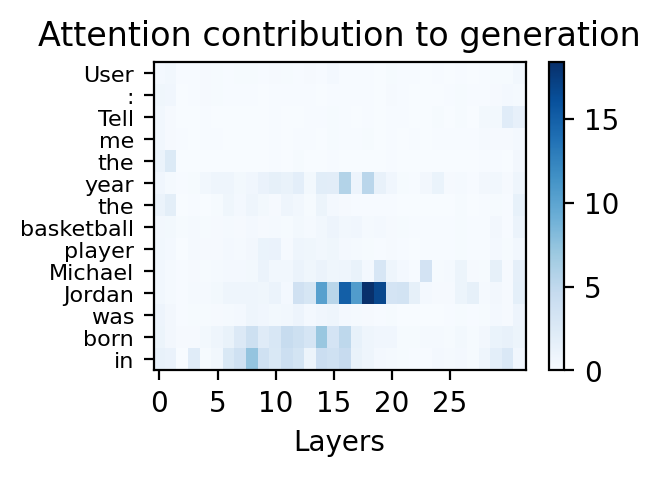

In [7]:
from viz_tools import plot_attention_flow
flow_matrix = data.all_token_contrib_norms[:, 1:data.num_prompt_tokens].T
# Get token labels 
token_labels = data.token_labels[1:data.num_prompt_tokens]
fig = plot_attention_flow(flow_matrix, token_labels, topk_prefix=14)
fig.savefig(f"./assets/sample_{item['player_name'].lower().replace(' ', '_')}.png", bbox_inches="tight")
